In [99]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import scipy as sp

In [100]:
def make_dataset(M=100, N=100, O=80, closeness=10):
    """
    Generate a set of ratings 1-5 by N observers, each of whom make M ratings
    Typically, we would assume the 0th row is the "ground truth" rater
    Assume O-1 observers are "good" and are similar to the ground truth
    Then there are N-O random raters leftover
    closeness controls how similar the good raters are to the ground truth, and should be an integer
    Roughly speaking, at closeness = N, there is a 1/(2N+1) chance any rating will deviate by 1
    """
    #ground truth always gets middling ratings from 2-3 so they can be adjusted later when making similar raters
    ground = np.random.randint(2,4,size=(1,M))
    #good raters have a low probability of deviating from the ground truth rater by 1 in either direction
    good = np.trunc(np.random.randint(-closeness,closeness+1,size=(O-1,M))/closeness)
    good += ground
    bad = np.random.randint(1,5,size=(N-O,M))
    
    return(np.concatenate((ground,good,bad),axis=0))

In [101]:
D = make_dataset(closeness=10)

First option: let's generate a scatter plot of distances between raters
If most raters give ratings similar to the ground truth rater, then they will cluster together
Raters who respond randomly or at least very differently from other raters will appear off on their own
This technique uses multidimensional scaling to convert the distance between raters to a distance on a map

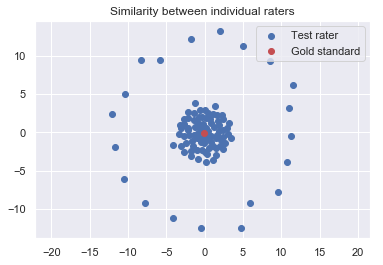

In [102]:
dist= sp.spatial.distance.pdist(D, metric='euclidean')
square = sp.spatial.distance.squareform(dist)

from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed')
out = model.fit_transform(square)
test = plt.scatter(out[1:, 0], out[1:, 1], color="b")
#the first point is considered ground truth - color it red
ground = plt.scatter(out[0:1,0], out[0:1,0], color="r")
plt.title("Similarity between individual raters")
plt.legend((test,ground),
           ('Test rater', 'Gold standard'))
plt.axis('equal');

Second option: the scatter plot lost information about *what* specifically was wrong
In particular, we can compare any set of people (including an individual) against ground truth

In [103]:
def make_ratings(base, N=1000, skew=0, variation=1):
    """Generates a list of ratings for a ground truth rating of base.
    Additionally, you can skew the ratings in some direction and introduce/control the variance.
    Returns a list of ratings, all integers, in the range [1,4]"""
    values = np.random.normal(base+skew,variation,size=N)
    return(np.clip(np.round(values), 1,4))

In [104]:
import pandas as pd

#make a dataframe of ratings seen by test raters, when the ground truth was actually a 1, 2, 3, or 4
#just for example's sake, here raters tend to be too positive when they should be giving a 1,
#too random when giving a 2, pretty accurate at giving a 3, and too negative and random when giving a 4
df = pd.DataFrame({'1':make_ratings(1, skew=1, variation=0.5),
                   '2':make_ratings(2, skew=0, variation=1),
                   '3':make_ratings(3, skew=-0.25, variation=0.25),
                   '4':make_ratings(4, skew=-1, variation=2)},dtype="category")
df = pd.melt(df, var_name="groundtruth", value_name="rating")

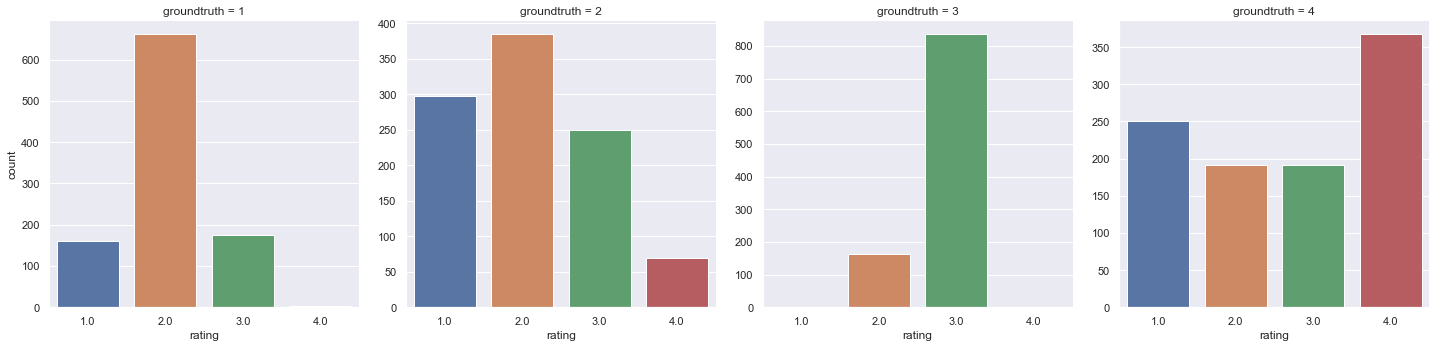

In [105]:
g = sns.catplot(data=df, x="rating", col="groundtruth", sharey=False, kind="count") 